# A simple example showing how to use VQE. 

For simplicity we start with a hamiltonion that maps simply to the hardware. The Heisenberg chain. 

$$ 
H = \frac{1}{2}\sum_{\mathrm{coupling}} (X_jX_{j+1} + Y_jY_{j+1} + Z_jZ_{j+1}) + \sum_{j=0}^{N-1} h_j Z_j
$$  
where 
$$
h_j \in [-1,1]
$$
and are randomly choosen and coupling is the coupling map of the processor

## **Step 0**: Setup

In [82]:
import numpy as np

from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.primitives import Estimator as AerEstimator

# Qiskit from IBM
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")
from rustworkx.visualization import graphviz_draw
%config InlineBackend.figure_format='retina'

In [2]:
backend = service.backend('ibm_nazca')
target = backend.target

## **Step 1** Map the problem to a Quantum Native format (Set of Operators, and a set of Quantum Circuits)

In [3]:
coupling = target.build_coupling_map()

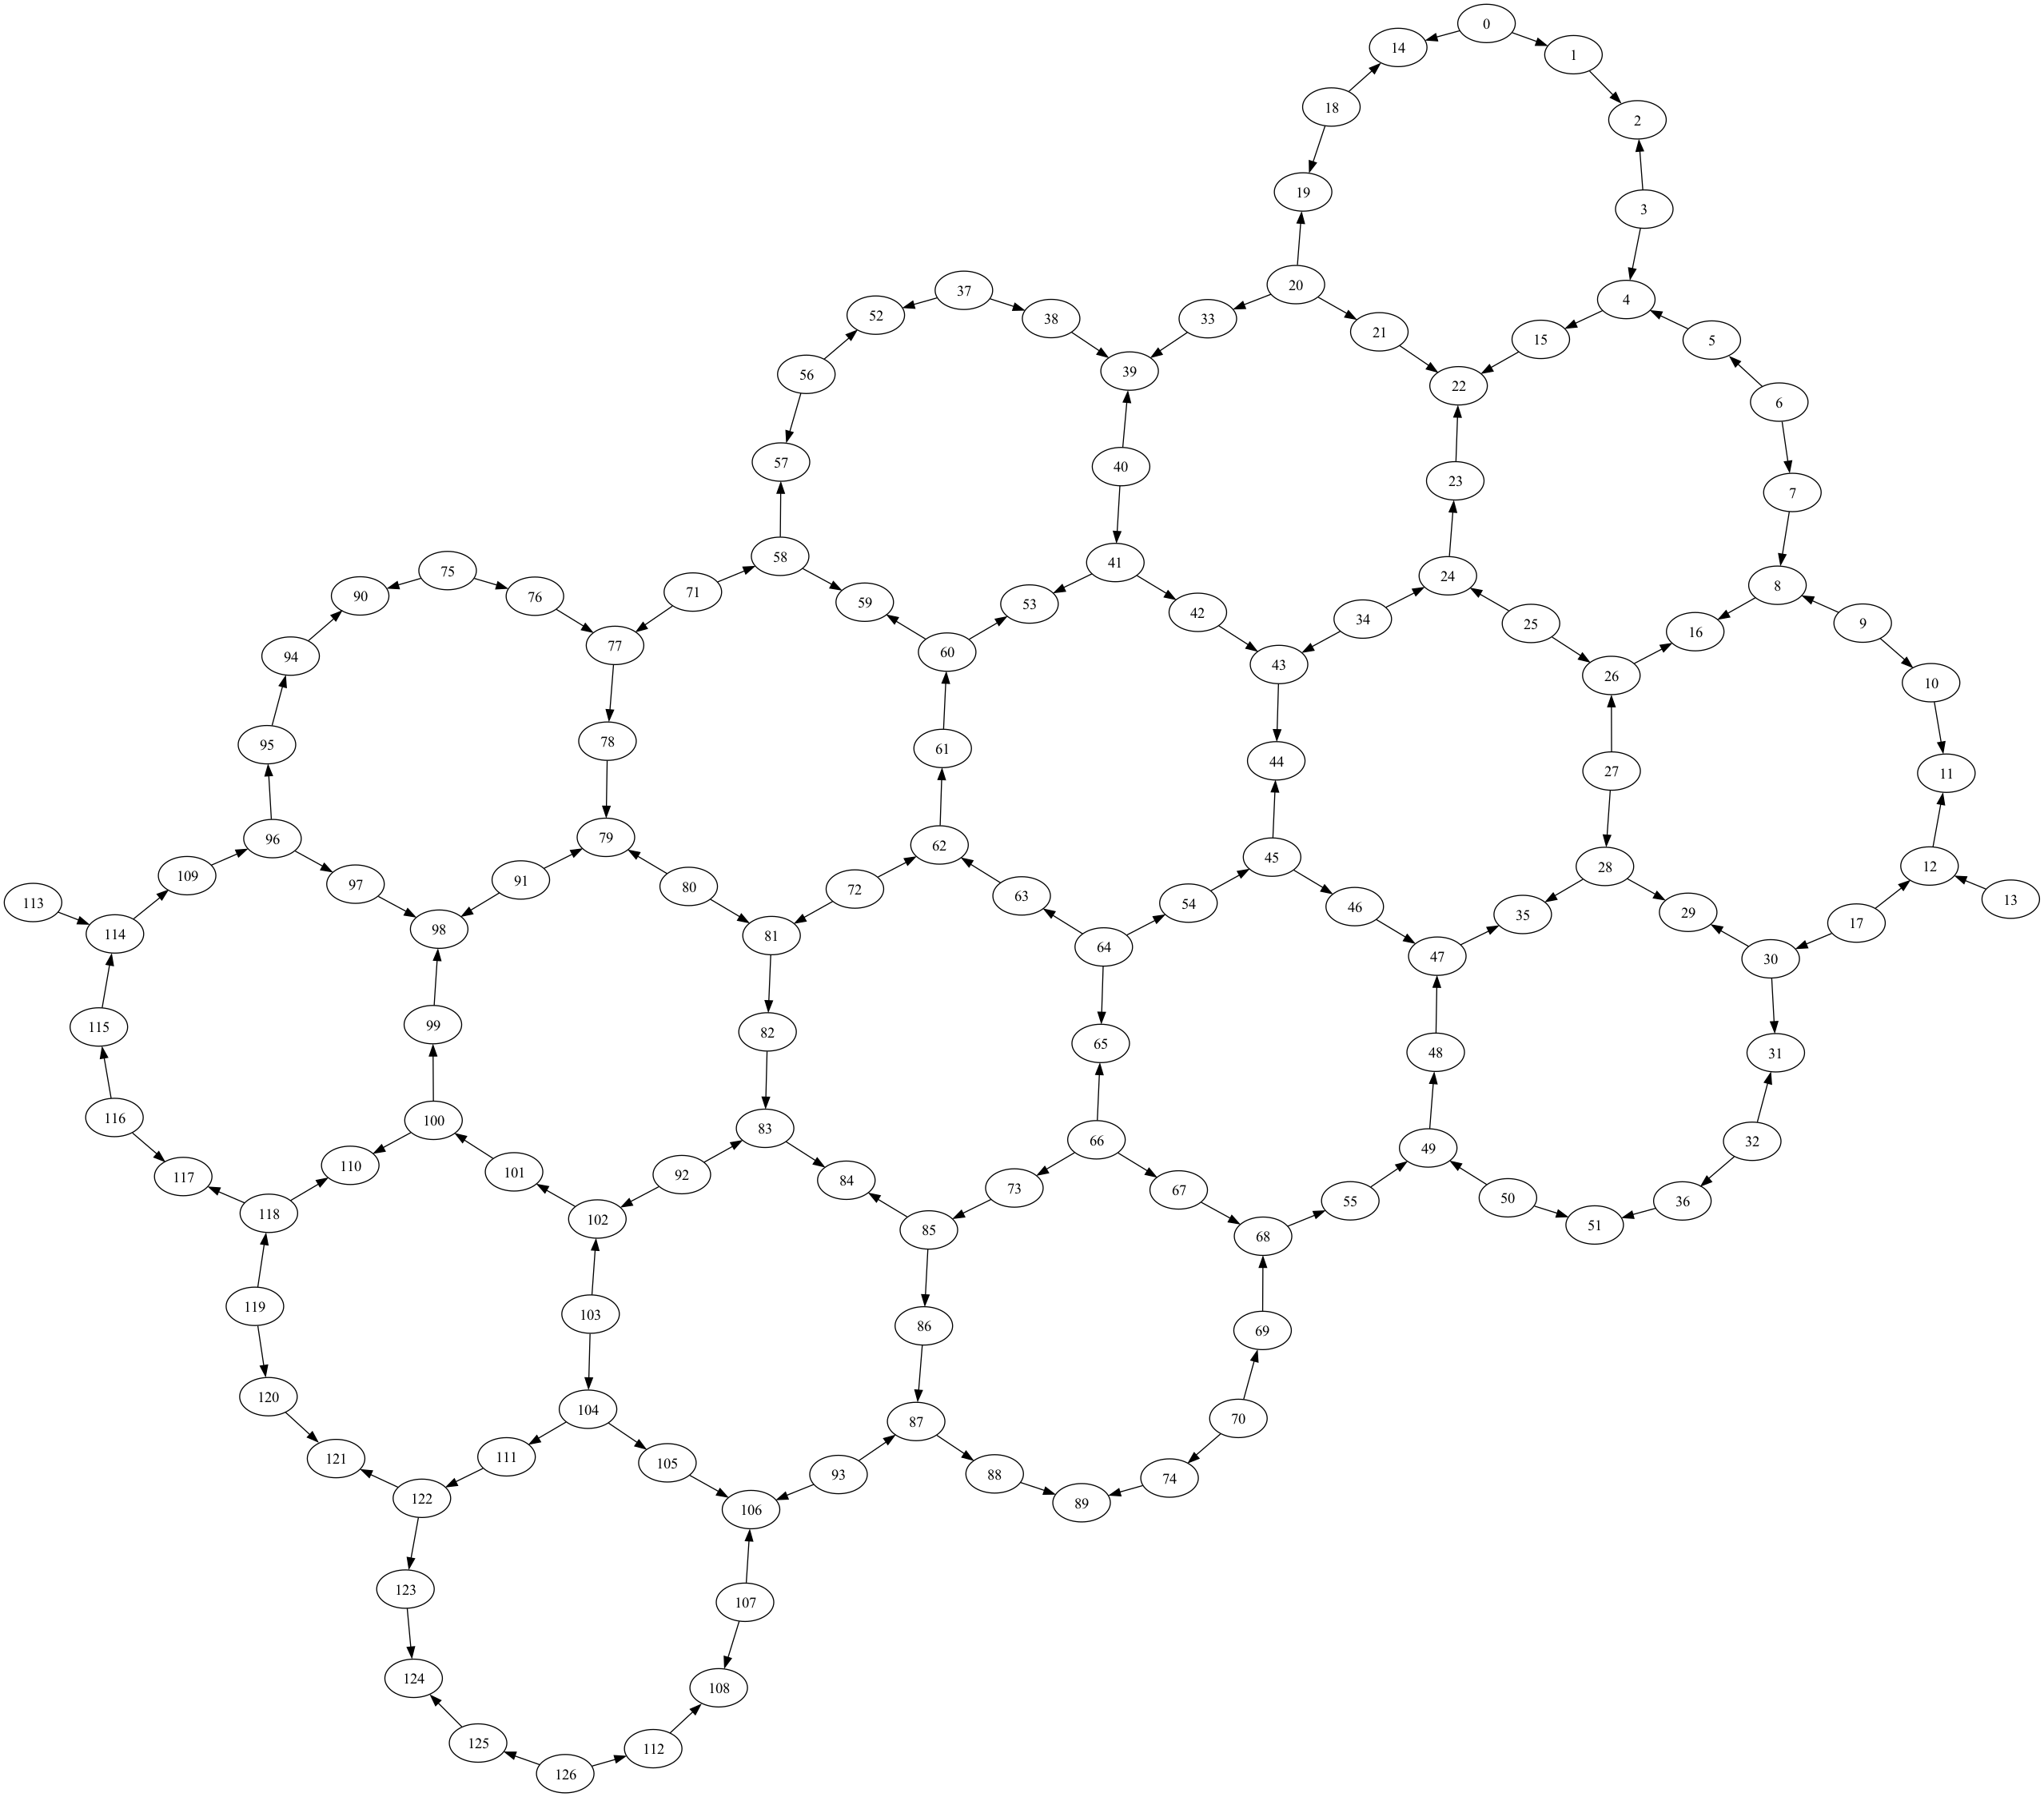

In [4]:
coupling.draw()

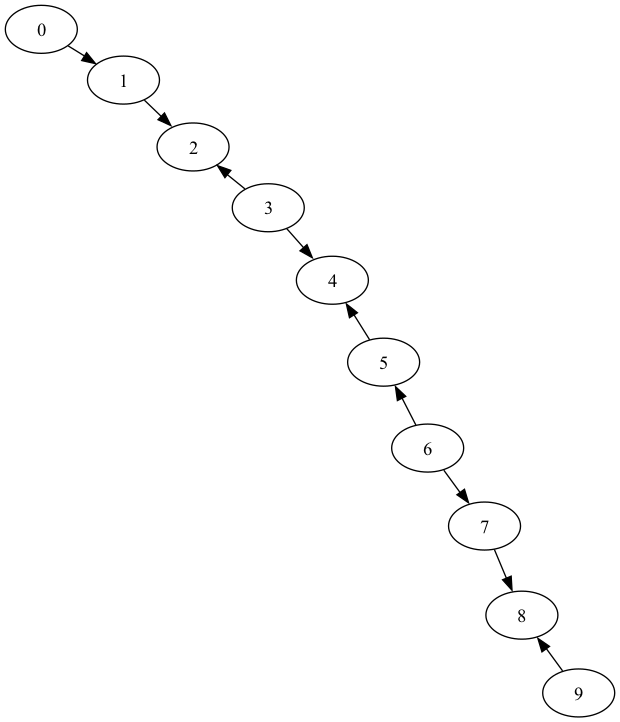

In [72]:
reduced_coupling=coupling.reduce(range(10))
reduced_coupling.draw()

In [73]:
from qiskit.quantum_info import SparsePauliOp

edgelist = reduced_coupling.graph.edge_list()
num_qubits = len(reduced_coupling.physical_qubits)
hamlist= []

for edge in edgelist:
    hamlist.append(('ZZ', edge, 0.5))
    hamlist.append(('YY', edge, 0.5))
    hamlist.append(('XX', edge, 0.5))

for qubit in reduced_coupling.physical_qubits:
    hamlist.append(('Z', [qubit], np.random.random()*2-1))

hamiltonian = SparsePauliOp.from_sparse_list(hamlist, num_qubits=num_qubits)
hamiltonian

SparsePauliOp(['IIIIZZIIII', 'IIIIYYIIII', 'IIIIXXIIII', 'IIIIIZZIII', 'IIIIIYYIII', 'IIIIIXXIII', 'ZZIIIIIIII', 'YYIIIIIIII', 'XXIIIIIIII', 'IIIIIIZZII', 'IIIIIIYYII', 'IIIIIIXXII', 'IIZZIIIIII', 'IIYYIIIIII', 'IIXXIIIIII', 'IIIIIIIZZI', 'IIIIIIIYYI', 'IIIIIIIXXI', 'IIIZZIIIII', 'IIIYYIIIII', 'IIIXXIIIII', 'IIIIIIIIZZ', 'IIIIIIIIYY', 'IIIIIIIIXX', 'IZZIIIIIII', 'IYYIIIIIII', 'IXXIIIIIII', 'IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[ 0.5       +0.j,  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,
  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,
  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,
  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,
  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,
  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,  0.5       +0.j,
  0.5       +0.j,  0.5       +0

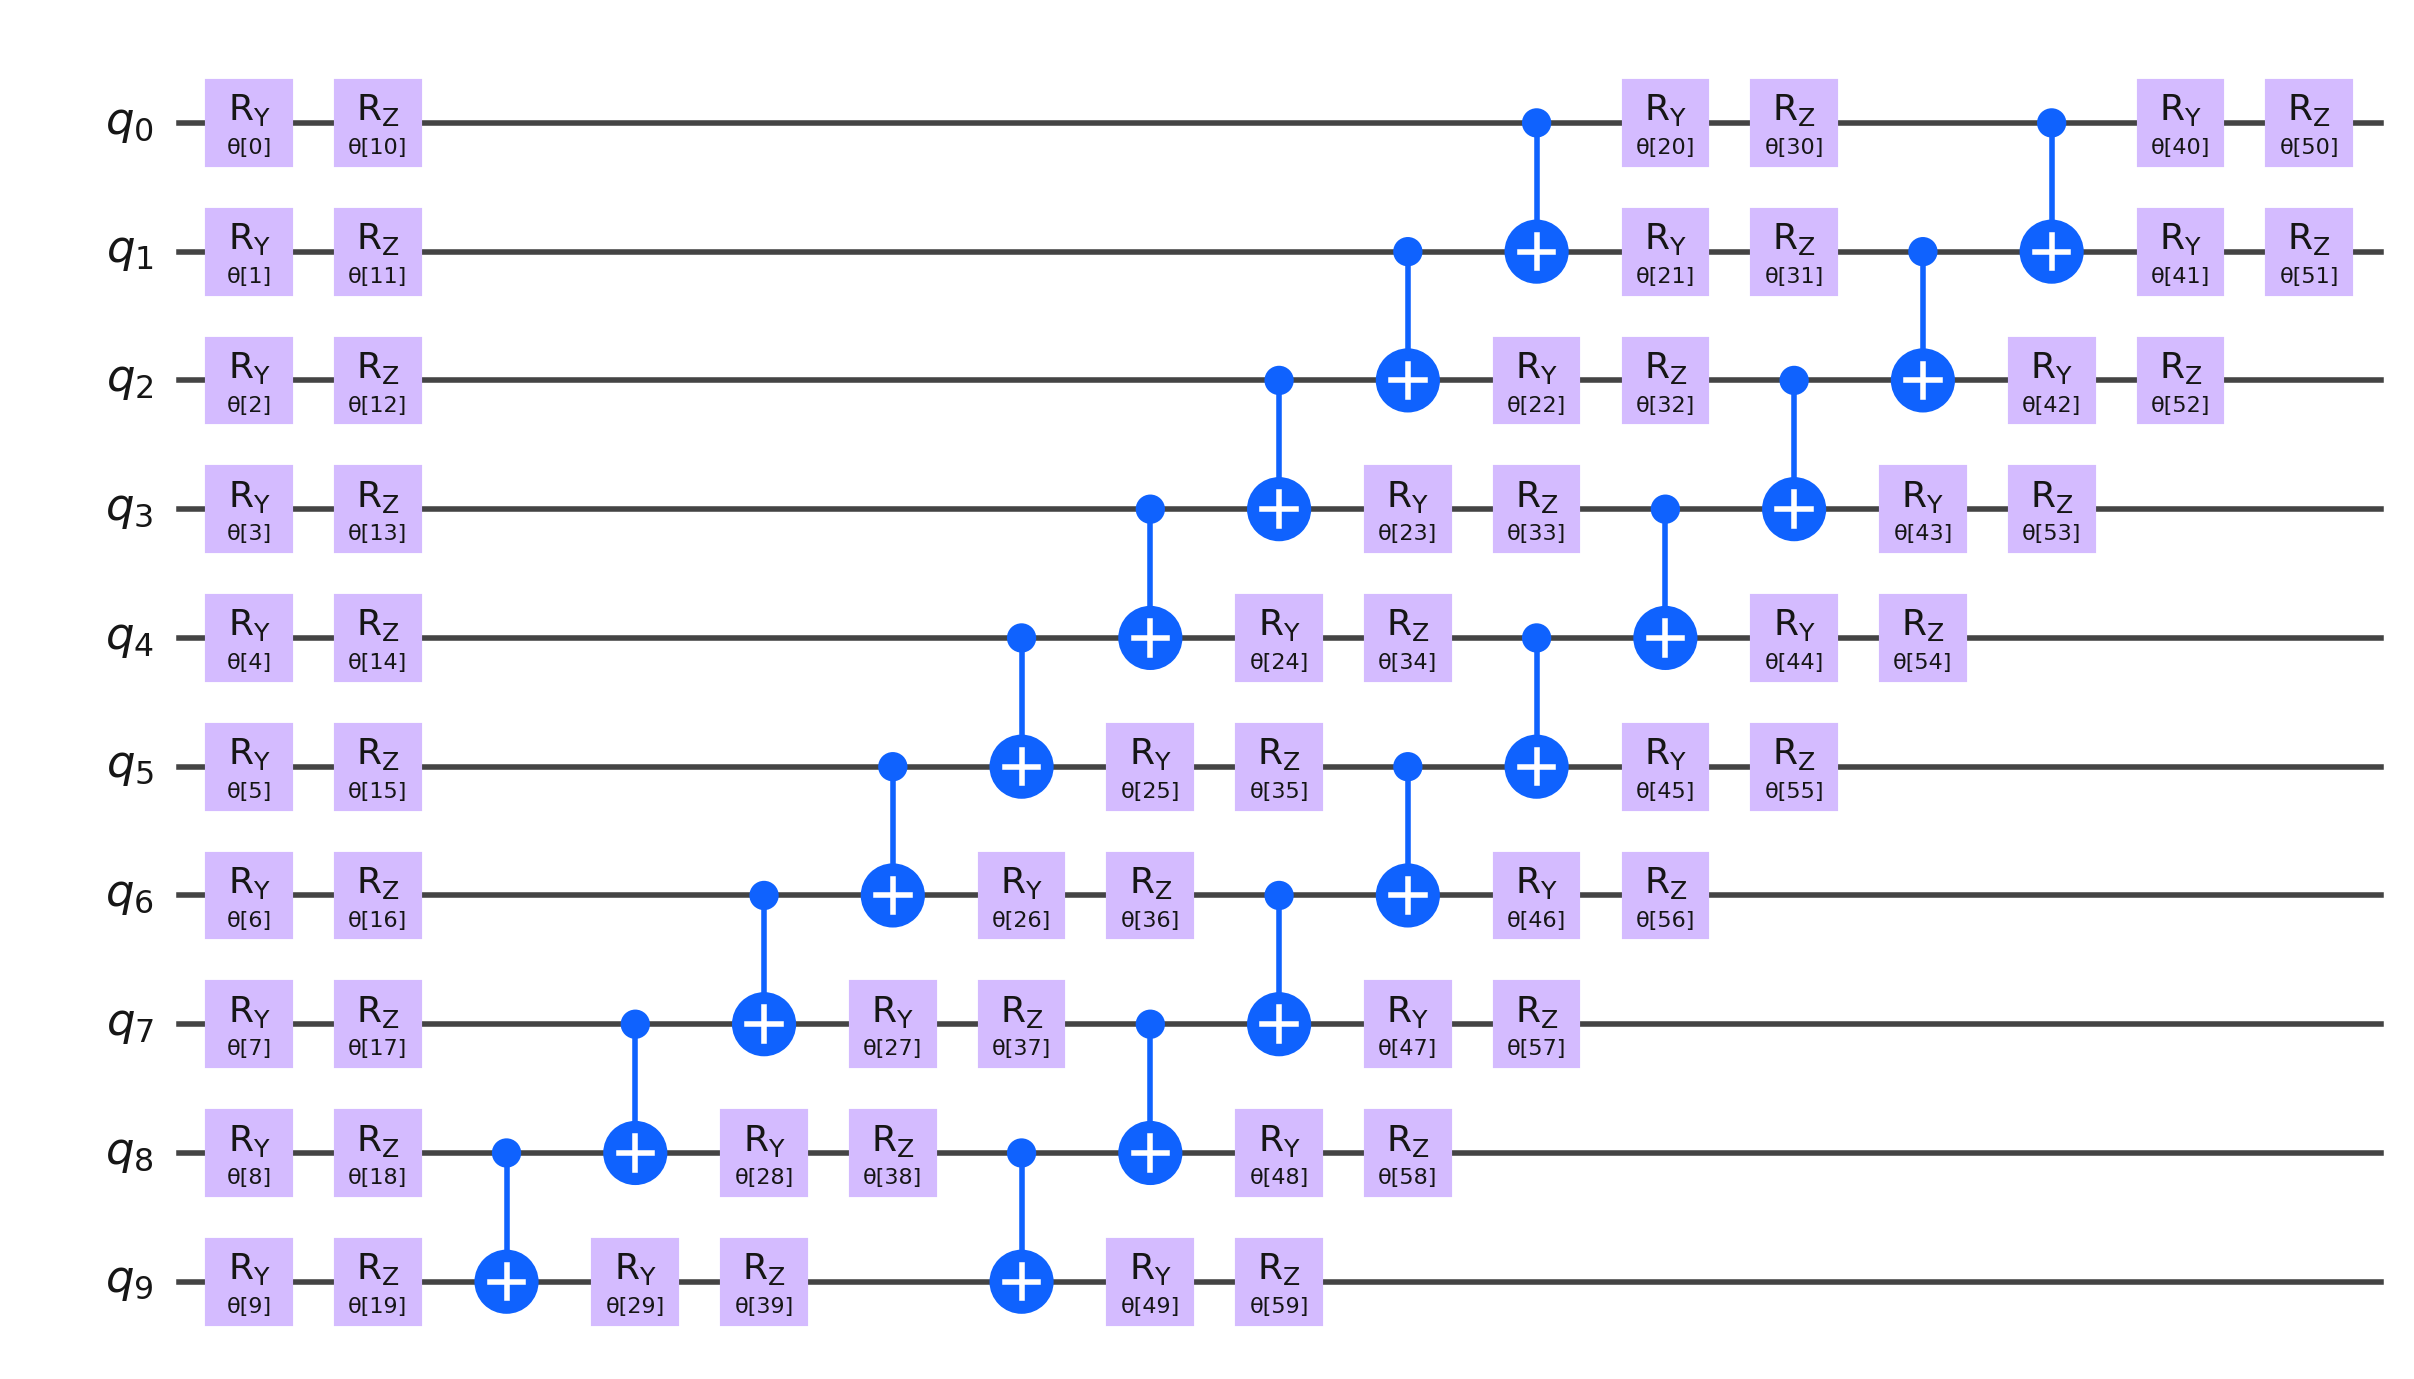

In [85]:
# Qiskit circuit library
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_qubits,reps=2)

ansatz.decompose().draw('mpl', idle_wires=False, fold=-1)

## **Step 2**: Optimize the circuits and the operators to be measured

In [75]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling, ConstrainedReschedule
from qiskit.circuit.library import XGate

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
        PadDynamicalDecoupling(target=target, dd_sequence=[XGate(), XGate()])
    ]
)

ansatz_ibm = pm.run(ansatz)

/Users/paul/mambaforge/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/paul/mambaforge/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


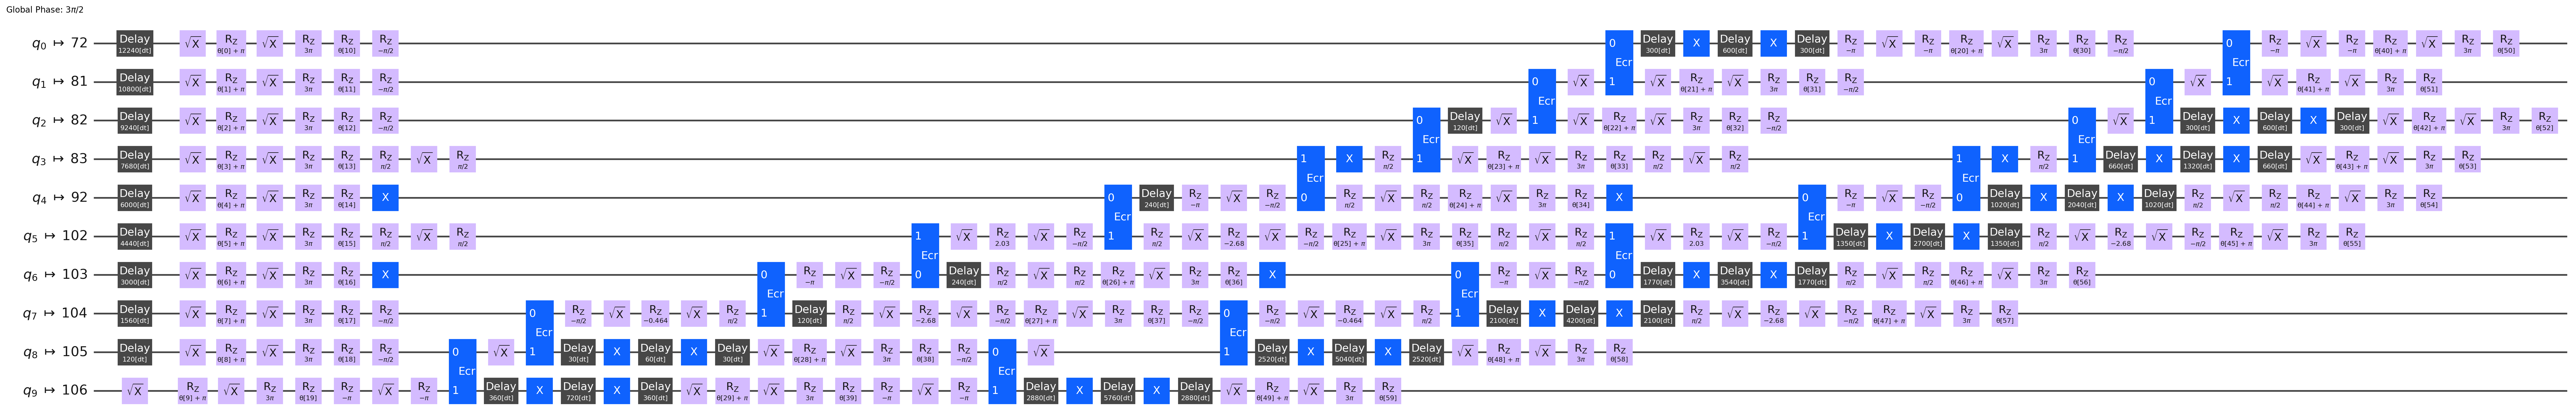

In [86]:
ansatz_ibm.draw('mpl', idle_wires=False, fold=-1)

In [77]:
layout = ansatz_ibm.layout
hamiltonian_ibm = hamiltonian.apply_layout(layout)

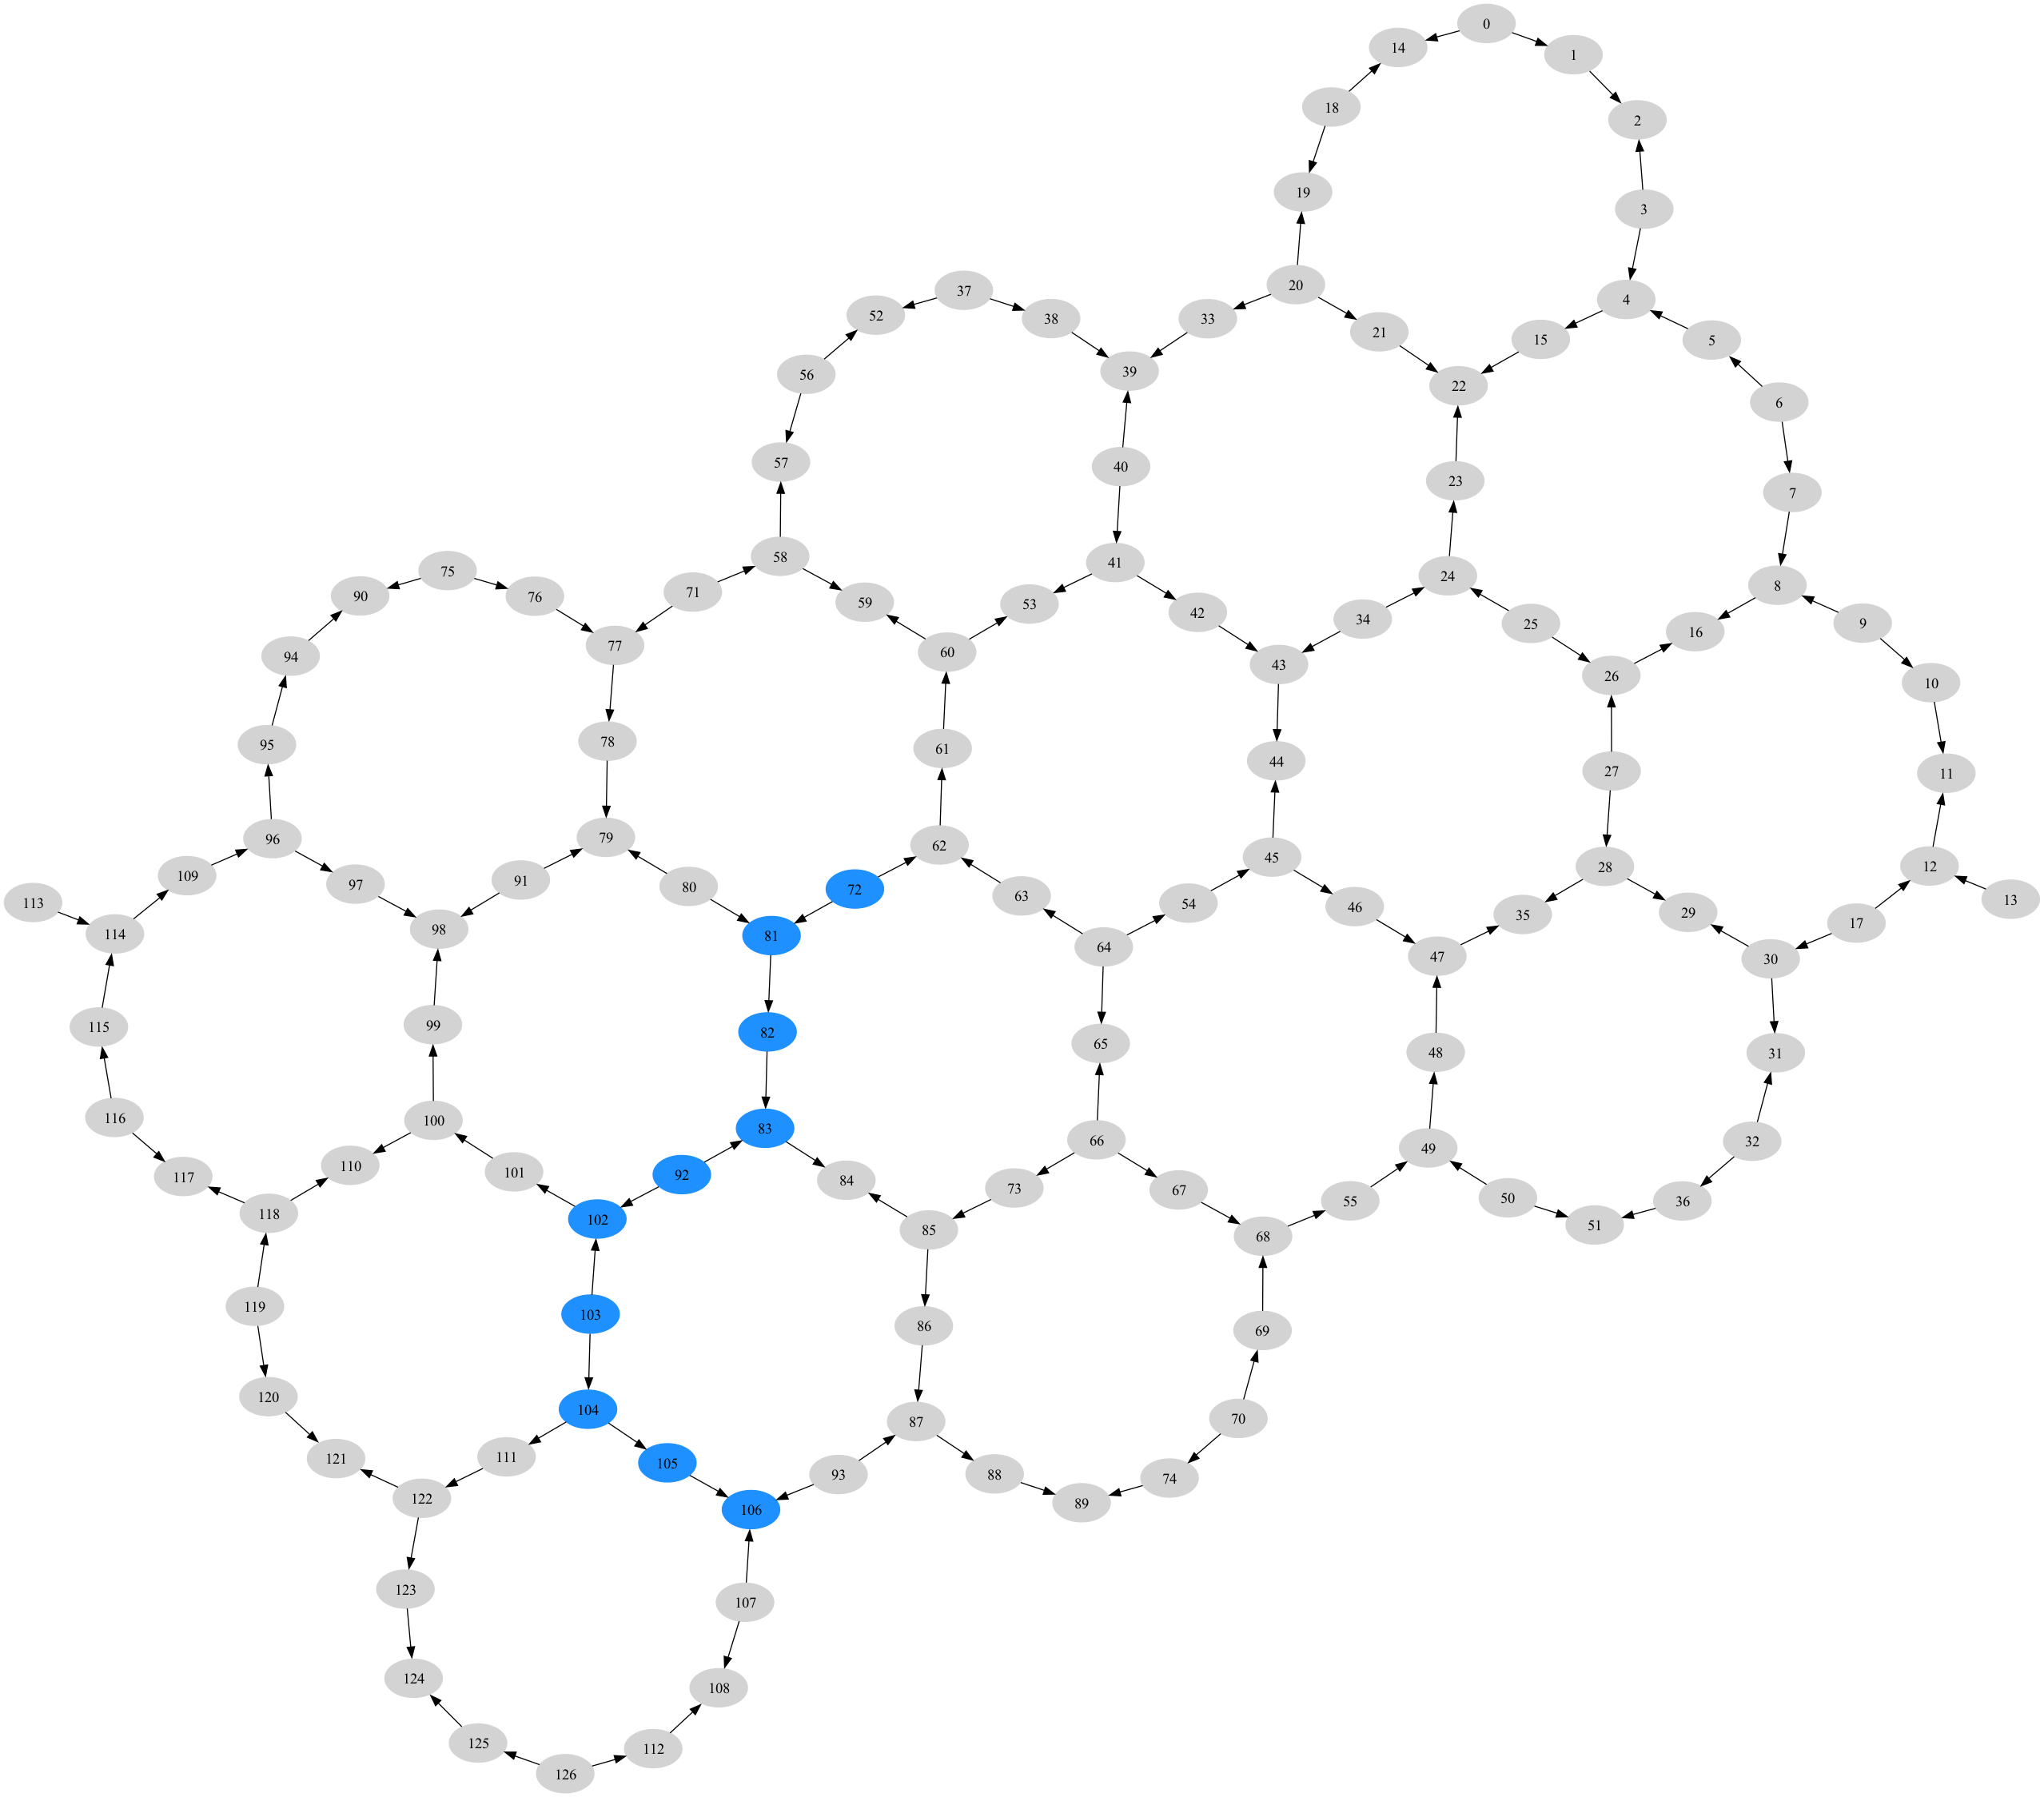

In [88]:
def node_attr(node):
    if node in layout.final_index_layout():
        return {'color': 'dodgerblue', 'fillcolor': 'dodgerblue', 'style': 'filled'}
    else:
        return {'color': 'lightgray', 'fillcolor': 'lightgray', 'style': 'filled'}
    
G = coupling.graph
for node in G.node_indices():
    G[node] = node
    
graphviz_draw(G, method="neato", node_attr_fn=node_attr)

## Step 3

In [ ]:
# Import SPSA from module until SPSA is part of scipy
from spsa import minimize_spsa
#from scipy.optimize import minimize

def cost_func(params, ansatz, hamiltonian, estimator):
        """Return estimate of energy from estimator

        Parameters:
            params (ndarray): Array of ansatz parameters
            ansatz (QuantumCircuit): Parameterized ansatz circuit
            hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
            estimator (Estimator): Estimator primitive instance

        Returns:
            float: Energy estimate
        """
        energy = estimator.run(ansatz, hamiltonian,
                               parameter_values=params).result().values[0]
        return energy


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = estimator.run(ansatz, hamiltonian,
                                     parameter_values=current_vector).result().values[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

num_params = ansatz_ibm.num_parameters
params = 2*np.pi*np.random.random(num_params)

options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 5000  # Options can be set using auto-complete.

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

with Session(service=service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    callback = build_callback(ansatz_ibm, hamiltonian_ibm, estimator, callback_dict)
    #res = minimize(cost_func, x0=params,
    #               args=(ansatz, hamiltonian, estimator),
    #               callback=callback,
    #               maxiter=100, method='coblya')
    res = minimize_spsa(cost_func, x0=params,
                        args=(ansatz_ibm, hamiltonian_ibm, estimator),
                        callback=callback,
                        maxiter=100)

In [ ]:
res

In [ ]:
import matplotlib.pyplot as plt

plt.plot(callback_dict['cost_history'], lw=2)
plt.axhline(y=np.linalg.eigvalsh(hamiltonian.to_matrix())[0], color='r', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.show()